In [7]:
import pandas as pd
import numpy as np
import igraph as ig
import chart_studio.plotly as ply
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy.spatial import ConvexHull
import random
import os
from pathlib import Path

In [2]:
raw_matrix = 'nucl_v5/ava_homology_pd_matrix_labeled_v5.1.tsv'
edge_matrix = 'nucl_v5/pd_matrix_edges_v1.csv'
id_mapping = '/Users/mf019/bioinformatics/longread_pangenome/plasmid_id/output/best_matches_v9_1kb.tsv'

In [110]:
def edges_from_matrix(matrix, output):
    df = pd.read_csv(matrix, sep='\t', index_col=0, header=0)

    source = []
    target = []
    weight = []

    for i in range(len(df.index)):
        for j in range(i+1, len(df.columns)):
            if df.iloc[i,j] > 0:
                if df.iloc[i,i] >= 1000 and df.iloc[j,j] > 1000:
                    source.append(df.index[i])
                    target.append(df.columns[j])
                    score = 2*df.iloc[i,j]/sum([df.iloc[i,i], df.iloc[j,j]])
                    weight.append(score)


    edge_df = pd.DataFrame({
        'Source': source,
        'Target': target,
        'weight': weight,
        'interaction': ['interacts'] * len(source)  # Add this line apparently.
    })
    edge_df.to_csv(output, index=False)
    print(f'saved edges to {output}')
    return edge_df

def create_igraph(edge_df):
    nodes = list(set(edge_df['Source'].to_list() + edge_df['Target'].to_list()))
    nodes = [str(node) for node in nodes]  # Convert all nodes to strings
    G = ig.Graph()
    G.add_vertices(nodes)
    edges = [(str(row['Source']), str(row['Target'])) for _, row in edge_df[['Source', 'Target']].iterrows()]
    G.add_edges(edges)
    G.es['weight'] = edge_df['weight'].tolist()
    return G, nodes  # Return both the graph and the order of nodes

def align_labels_and_groups(idmap, vertex_order):
    longread_idmap = idmap[idmap['method'] == 'longread']
    # Create a dictionary mapping contig names to their labels and groups
    node_dict = longread_idmap.apply(lambda x: f"{x['name']}_{x['contig']}", axis=1)
    node_dict = dict(zip(node_dict, longread_idmap['best_hit']))

    aligned_labels = []
    aligned_groups = []

    print("Sample of idmap:")
    print(longread_idmap.head())

    print("\nSample of vertex_order:")
    print(vertex_order[:10])

    for vertex in vertex_order:
        if vertex in node_dict:
            if node_dict[vertex] == 'cp32-2':
                aligned_groups.append('cp32-7')
            elif node_dict[vertex] == 'cp32-9-4':
                aligned_groups.append('cp32-9')
            elif vertex == 'URI88H_contig000014':
                aligned_groups.append('lp21-cp9')
            else:
                aligned_groups.append(node_dict[vertex])
            aligned_labels.append(vertex)
        else:
            print(f'cannot find {vertex} in node_dict!')
            aligned_labels.append(vertex)
            aligned_groups.append('unknown')

    print(f"\nTotal vertices: {len(vertex_order)}")
    print(f"Aligned labels: {len(aligned_labels)}")
    print(f"Aligned groups: {len(aligned_groups)}")
    print(f"Sample of aligned labels: {aligned_labels[:10]}")
    print(f"Sample of aligned groups: {aligned_groups[:10]}")
    print(f"Unique groups: {set(aligned_groups)}")

    return aligned_labels, aligned_groups

# random colors
# def create_color_mapping(groups):
#    unique_groups = list(set(groups))
#    n_colors = len(unique_groups)
#    colors = px.colors.qualitative.Plotly * (n_colors // len(px.colors.qualitative.Plotly) + 1)
#    #colors = px.colors.qualitative.Plotly[:n_colors]
#    return {group: colors[i] for i, group in enumerate(unique_groups)}

def create_color_mapping(groups):
    color_map = {
        "cp26": "#d60000", "lp54": "#018700", "lp17": "#b500ff", "lp28-3": "#05acc6",
        "lp28-4": "#97ff00", "lp38": "#ffa52f", "cp32-7": "#ff8ec8", "cp32-4": "#79525e",
        "lp36": "#00fdcf", "cp32-6": "#afa5ff", "lp25": "#93ac83", "lp28-1": "#9a6900",
        "cp32-3": "#366962", "cp32-9": "#d3008c", "cp32-5": "#fdf490", "cp32-11": "#c86e66",
        "cp32-12": "#9ee2ff", "cp32-10": "#00c846", "cp32-3+10": "#1daf50","lp28-2": "#a877ac", "lp28-6": "#b8ba01",
        "lp21": "#f4bfb1", "lp28-5": "#ff28fd", "cp32-8": "#f2cdff", "cp32-1": "#009e7c",
        "cp9": "#ff6200", "lp56": "#56642a", "lp28-7": "#953f1f", "cp32-13": "#90318e",
        "lp5": "#ff3464", "lp21-cp9": "#a0e491", "cp9-3": "#8c9ab1", "lp28-8": "#829026",
        "lp28-9": "#ae083f", "lp28-11": "#c677b4", "chromosome": "#9eecff", 'none': 'hsla(0, 0.00%, 0.00%, 0.00)'
    }

    # For any groups not in the predefined color_map, assign a random color
    unique_groups = set(groups)
    for group in unique_groups:
        if group not in color_map:
            color_map[group] = 'hsla(0, 0.00%, 0.00%, 0.00)'
            print(f"uh oh! {group}")
    return color_map


def make_3d_plot(G, labels, groups, output_file):
    layout = G.layout('kk', dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]

    Xe = []
    Ye = []
    Ze = []

    for e in G.es:
        Xe += [layout[e.source][0],layout[e.target][0], None]
        Ye += [layout[e.source][1],layout[e.target][1], None]
        Ze += [layout[e.source][2],layout[e.target][2], None]

    color_map = create_color_mapping(groups)
    color_values = [color_map[group] for group in groups]

    trace1 = go.Scatter3d(
        x = Xe,
        y = Ye,
        z = Ze,
        mode = 'lines',
        line = dict(
            color = 'rgb(125,125,125)',
            width=0.5,
            ),
        opacity=0.7,
        hoverinfo = 'none'
    )

    trace2 = go.Scatter3d(
        x = Xn,
        y = Yn,
        z = Zn,
        mode = 'markers',
        name = 'contigs',
        marker = dict(
            symbol='circle',
            size=8,
            color=color_values,
            colorscale='Viridis',
            line=dict(color='rgb(50,50,50)', width=0.5),
        ),
        text=labels,
        hoverinfo = 'text'
    )
    # create opacity slider
    steps = []
    for step in np.arange(0, 1.1, 0.1):
        step = round(step, 2)
        steps.append(
            dict(
                method="update",
                args=[{"opacity": [step, 1]}],  # Update only trace1 (edges)
                label=str(step)
            )
        )

    # edge opacity slider
    sliders = [dict(
        active=7,
        currentvalue={"prefix": "Edge Opacity: "},
        pad={"t": 40},
        steps=steps
    )]

    layout3d = go.Layout(
        title="Sequence Homology between contigs across 49 long-read assemblies (3D)",
        width=1900,
        height=750,
        showlegend=False,
        scene=dict(
            xaxis=dict(title=''),
            yaxis=dict(title=''),
            zaxis=dict(title=''),
        ),
        margin=dict(r=0, l=0, b=0, t=100),
        hovermode='closest',
        annotations=[
            dict(
                showarrow=False,
                text="MJF-2024",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=dict(
                    size=8
                )
            )
        ],
        sliders=sliders
        )
    data=[trace1, trace2]
    fig = go.Figure(data, layout=layout3d)
    fig.update_layout(
        scene_aspectmode='data',
        autosize=True
        )
    config = {
        'responsive': True,
        'scrollZoom': True,
    }
    pio.write_html(fig, file=output_file, full_html=False, include_plotlyjs='cdn', config=config)
    print("html written!")
# useful lambda
#labels = idmap.apply(lambda x: f"{x['name']}_{x['contig']}" if x['method'] == 'longread' else '', axis=1)
#labels = labels[labels != '']
#groups = list(set(idmap['best_hit']))

In [4]:
#def create_color_mapping(groups):
#    custom_palette = [
#    '#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#33FFF6', '#F633FF', '#FF33A1', '#33FFA1',
#    '#A1FF33', '#FFA133', '#33A1FF', '#A133FF', '#FF33F6', '#bdc258', '#FF33D4', '#33FFD4',
#    '#D4FF33', '#FFD433', '#33D4FF', '#D433FF', '#FF5733', '#33FF57', '#3357FF', '#F3FF33',
#    '#33FFF6', '#F633FF', '#FF33A1', '#33FFA1', '#A1FF33', '#FFA133', '#33A1FF', '#A133FF',
#    '#FF33F6', '#F6FF33', '#FF33D4', '#33FFD4', '#D4FF33', '#FFD433', '#33D4FF', '#D433FF',
#    '#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#33FFF6', '#F633FF', '#FF33A1', '#33FFA1',
#    '#A1FF33', '#FFA133'
#    ]
#    unique_groups = list(set(groups))
#    n_colors = len(unique_groups)
#
#    # Repeat the custom palette as needed to match the number of unique groups
#    colors = custom_palette * (n_colors // len(custom_palette) + 1)
#
#    # Slice to ensure only n_colors are used
#    return {group: colors[i] for i, group in enumerate(unique_groups)}

In [84]:
def make_3d_plot_v2(G, labels, groups, output_file, layout):
    layout = G.layout(layout, dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]

    color_map = create_color_mapping(groups)
    color_values = [color_map[group] for group in groups]

    # Create a list of unique groups
    unique_groups = list(set(groups))
    print(unique_groups)

    # Create a single edge trace for all connections
    Xe, Ye, Ze = [], [], []
    for e in G.es:
        Xe += [layout[e.source][0], layout[e.target][0], None]
        Ye += [layout[e.source][1], layout[e.target][1], None]
        Ze += [layout[e.source][2], layout[e.target][2], None]

    edge_trace = go.Scatter3d(
        x=Xe,
        y=Ye,
        z=Ze,
        mode='lines',
        name='Edges',
        line=dict(color='rgb(125,125,125)', width=0.35),
        hoverinfo='none',
        showlegend=False
    )

    # Create node traces for each group
    node_traces = []
    for group in unique_groups:
        group_indices = [i for i, g in enumerate(groups) if g == group]
        node_traces.append(
            go.Scatter3d(
                x=[Xn[i] for i in group_indices],
                y=[Yn[i] for i in group_indices],
                z=[Zn[i] for i in group_indices],
                mode='markers',
                name=group,
                marker=dict(
                    symbol='circle',
                    size=6,
                    color=color_map[group],
                    line=dict(color='rgb(38, 38, 38)', width=0.35),
                ),
                #text=[labels[i] for i in group_indices],
                text=[f'Label: {labels[i]}<br>Group: {group}' for i in group_indices],
                hoverinfo='text'
            )
        )

    # Combine all traces
    data = [edge_trace] + node_traces

    # Create slider for edge opacity
    steps = []
    for step in np.arange(0, 1.1, 0.1):
        step = round(step, 2)
        steps.append(
            dict(
                method="update",
                args=[{"opacity": [step, *[1]*len(node_traces)]}],  # First trace is edges, rest are nodes
                label=str(step)
            )
        )

    sliders = [dict(
        active=5,
        currentvalue={"prefix": "Edge Opacity: "},
        pad={"t": 5, "b": 10},
        steps=steps
    )]

    layout3d = go.Layout(
        title="Sequence Homology between contigs across 49 long-read assemblies (3D)",
        scene=dict(
            xaxis=dict(title=''),
            yaxis=dict(title=''),
            zaxis=dict(title=''),
        ),
        margin=dict(r=0, l=0, b=0, t=100),
        hovermode='closest',
        legend=dict(
            itemsizing='constant',
            title_text='Plasmids',
            bgcolor='rgba(255,255,255,0.5)',
            bordercolor='rgba(0,0,0,0)',
            borderwidth=2
        ),
        sliders=sliders,
        #annotations=[
        #    dict(
        #        showarrow=False,
        #        text="MJF-2024",
        #        xref='paper',
        #        yref='paper',
        #        x=0,
        #        y=0.1,
        #        xanchor='left',
        #        yanchor='bottom',
        #        font=dict(
        #            size=8
        #        )
        #    )
        #]
    )

    fig = go.Figure(data=data, layout=layout3d)

    fig.update_layout(
        scene_aspectmode='data',
        autosize=True,
        uirevision=True
    )

    config = {
        'responsive': True,
        'scrollZoom': True,
    }

    img = pio.to_image(fig, 'png')
    with open(f'{Path(output_file).stem}.png', 'wb') as outfile:
        outfile.write(img)

    pio.write_html(fig, file=output_file, full_html=False, include_plotlyjs='cdn', config=config)
    print("html written!")

In [28]:
def make_3d_plot_v2_png(G, labels, groups, output_file, layout):
    layout = G.layout(layout, dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]

    color_map = create_color_mapping(groups)
    color_values = [color_map[group] for group in groups]

    # Create a list of unique groups
    unique_groups = list(set(groups))
    print(unique_groups)

    # Create a single edge trace for all connections
    Xe, Ye, Ze = [], [], []
    for e in G.es:
        Xe += [layout[e.source][0], layout[e.target][0], None]
        Ye += [layout[e.source][1], layout[e.target][1], None]
        Ze += [layout[e.source][2], layout[e.target][2], None]

    # Create node traces for each group
    node_traces = []
    for group in unique_groups:
        group_indices = [i for i, g in enumerate(groups) if g == group]
        node_traces.append(
            go.Scatter3d(
                x=[Xn[i] for i in group_indices],
                y=[Yn[i] for i in group_indices],
                z=[Zn[i] for i in group_indices],
                mode='markers',
                name=group,
                marker=dict(
                    symbol='circle',
                    size=6,
                    color=color_map[group],
                    line=dict(color='rgb(38, 38, 38)', width=0.35),
                ),
                #text=[labels[i] for i in group_indices],
                text=[f'Label: {labels[i]}<br>Group: {group}' for i in group_indices],
                hoverinfo='text'
            )
        )

    # Combine all traces
    data = node_traces

    # Create slider for edge opacity
    steps = []
    for step in np.arange(0, 1.1, 0.1):
        step = round(step, 2)
        steps.append(
            dict(
                method="update",
                args=[{"opacity": [step, *[1]*len(node_traces)]}],  # First trace is edges, rest are nodes
                label=str(step)
            )
        )

    layout3d = go.Layout(
        title="Sequence Homology between contigs across 49 long-read assemblies (3D)",
        scene=dict(
            xaxis=dict(title=''),
            yaxis=dict(title=''),
            zaxis=dict(title=''),
        ),
        margin=dict(r=0, l=0, b=0, t=100),
        hovermode='closest',
        legend=dict(
            itemsizing='constant',
            title_text='Plasmids',
            bgcolor='rgba(255,255,255,0.5)',
            bordercolor='rgba(0,0,0,0)',
            borderwidth=2
        ),
        #sliders=sliders,
        #annotations=[
        #    dict(
        #        showarrow=False,
        #        text="MJF-2024",
        #        xref='paper',
        #        yref='paper',
        #        x=0,
        #        y=0.1,
        #        xanchor='left',
        #        yanchor='bottom',
        #        font=dict(
        #            size=8
        #        )
        #    )
        #]
    )

    fig = go.Figure(data=data, layout=layout3d)

    fig.update_layout(
        scene_aspectmode='data',
        autosize=True,
        uirevision=True
    )

    config = {
        'responsive': True,
        'scrollZoom': True,
    }

    img = pio.to_image(fig, 'png', width=1000, height=1000, scale=1)
    with open(f'{Path(output_file).stem}.png', 'wb') as outfile:
        outfile.write(img)

    #pio.write_html(fig, file=output_file, full_html=False, include_plotlyjs='cdn', config=config)
    print("png written!")

In [6]:
def make_3d_plot_v3(G, labels, groups, output_file):
    layout = G.layout('kk', dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]
    color_map = create_color_mapping(groups)

    # Create a list of unique groups
    unique_groups = list(set(groups))
    print(len(unique_groups))
    # Create edge traces for connections between each pair of groups
    edge_traces = []
    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups[i:], i):  # Start from i to avoid duplicates
            Xe, Ye, Ze = [], [], []
            for e in G.es:
                if (groups[e.source] == group1 and groups[e.target] == group2) or (groups[e.source] == group2 and groups[e.target] == group1):
                    Xe += [layout[e.source][0], layout[e.target][0], None]
                    Ye += [layout[e.source][1], layout[e.target][1], None]
                    Ze += [layout[e.source][2], layout[e.target][2], None]
            if Xe:  # Only add the trace if there are edges
                edge_traces.append(
                    go.Scatter3d(
                        x=Xe,
                        y=Ye,
                        z=Ze,
                        mode='lines',
                        name=group1,
                        line=dict(color='rgb(125,125,125)', width=0.5),
                        hoverinfo='skip',
                        showlegend=False,
                        visible=True
                    )
                )
    print(len(edge_traces))
    # Create node traces for each group
    node_traces = []
    for group in unique_groups:
        group_indices = [i for i, g in enumerate(groups) if g == group]
        node_traces.append(
            go.Scatter3d(
                x=[Xn[i] for i in group_indices],
                y=[Yn[i] for i in group_indices],
                z=[Zn[i] for i in group_indices],
                mode='markers',
                name=group,
                marker=dict(
                    symbol='circle',
                    size=8,
                    color=color_map[group],
                    line=dict(color='rgb(50,50,50)', width=0.5),
                ),
                text=[labels[i] for i in group_indices],
                hoverinfo='text'
            )
        )
    print(len(node_traces))

    # Combine all traces
    data = edge_traces + node_traces

    updatemenus = [
        dict(
            buttons=[
                dict(
                    args=[{'visible': [True] * len(data)}],
                    label='Show All',
                    method='update'
                ),
                dict(
                    args=[{'visible': [False] * len(edge_traces) + [True] * len(node_traces)}],
                    label='Hide All Edges',
                    method='update'
                )
            ] + [
                dict(
                    # Set False for edge traces with None as name, or check group in valid names
                    args=[{'visible': [(trace.name is not None and group in trace.name) for trace in edge_traces] + [True] * len(node_traces)}],
                    label=f'Show only {group} edges',
                    method='update'
                ) for group in unique_groups
            ],
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='right',
            y=1.1,
            yanchor='top'
        )
    ]

    # Create slider for edge opacity
    steps = []
    for step in np.arange(0, 1.1, 0.1):
        step = round(step, 2)
        steps.append(
            dict(
                method="update",
                args=[{"opacity": [step] * len(edge_traces) + [1] * len(node_traces)}],
                label=str(step)
            )
        )

    sliders = [dict(
        active=5,
        currentvalue={"prefix": "Edge Opacity: "},
        pad={"t": 50},
        steps=steps
    )]

    layout3d = go.Layout(
        title="Sequence Homology between contigs across 49 long-read assemblies (3D)",
        scene=dict(
            xaxis=dict(title=''),
            yaxis=dict(title=''),
            zaxis=dict(title=''),
        ),
        updatemenus=updatemenus,
        margin=dict(r=0, l=0, b=0, t=100),
        hovermode='closest',
        legend=dict(
            itemsizing='constant',
            title_text='Plasmids',
            bgcolor='rgba(255,255,255,0.5)',
            bordercolor='rgba(0,0,0,0)',
            borderwidth=2
        ),
        sliders=sliders,
        annotations=[
            dict(
                showarrow=False,
                text="MJF-2024",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=dict(
                    size=8
                )
            )
        ]
    )

    fig = go.Figure(data=data, layout=layout3d)
    fig.update_layout(
        scene_aspectmode='data',
        autosize=True,
        uirevision=True
    )

    config = {
        'responsive': True,
        'scrollZoom': True,
    }

    pio.write_html(fig, file=output_file, full_html=False, include_plotlyjs='cdn', config=config)
    print("html written!")

In [7]:
def generate_coordinates(G):
    layout = G.layout('kk', dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]

    Xe, Ye, Ze = [], [], []
    for e in G.es:
        Xe += [layout[e.source][0], layout[e.target][0], None]
        Ye += [layout[e.source][1], layout[e.target][1], None]
        Ze += [layout[e.source][2], layout[e.target][2], None]

    return Xn, Yn, Zn, Xe, Ye, Ze

def generate_meshes(Xn, Yn, Zn, groups, color_map):
    mesh_traces = []
    unique_groups = set(groups)

    for group in unique_groups:
        group_indices = [i for i, g in enumerate(groups) if g == group]
        if len(group_indices) < 4:
            continue
        group_points = np.array(
            [[Xn[i], Yn[i], Zn[i]] for i in group_indices]
        )
        vertices = hull.simplices

        mesh_trace = go.Mesh3d(
            x=group_points[:, 0],
            y=group_points[:, 1],
            z=group_points[:, 2],
            i=vertices[:, 0],
            j=vertices[:, 1],
            k=vertices[:, 2],
            color=color_map[group],
            opacity=0.3,
            name=f'Group {group}'
        )
        mesh_traces.append(mesh_trace)
    return mesh_traces

def make_3d_mesh_plot(G, labels, groups, output_file):
    # Generate coordinates
    Xn, Yn, Zn, Xe, Ye, Ze = generate_coordinates(G)

    # Create color mapping
    color_map = create_color_mapping(groups)
    color_values = [color_map[group] for group in groups]

    # Create edge trace
    trace1 = go.Scatter3d(
        x=Xe, y=Ye, z=Ze,
        mode='lines',
        line=dict(color='rgb(125,125,125)', width=0.5),
        opacity=0.7,
        hoverinfo='none'
    )

    # Create node trace
    trace2 = go.Scatter3d(
        x=Xn, y=Yn, z=Zn,
        mode='markers',
        name='contigs',
        marker=dict(
            symbol='circle',
            size=5,
            color=color_values,
            colorscale='Viridis',
            line=dict(color='rgb(50,50,50)', width=0.5),
        ),
        text=labels,
        hoverinfo='text'
    )

    # Generate meshes
    mesh_traces = generate_meshes(Xn, Yn, Zn, groups, color_map)

    # Combine all traces
    data = [trace1, trace2] + mesh_traces

    # Create layout
    layout3d = go.Layout(
        title="Sequence Homology between contigs across 49 long-read assemblies (3D)",
        width=1900,
        height=750,
        showlegend=True,
        scene=dict(
            xaxis=dict(title=''),
            yaxis=dict(title=''),
            zaxis=dict(title=''),
        ),
        margin=dict(r=0, l=0, b=0, t=100),
        hovermode='closest',
        annotations=[
            dict(
                showarrow=False,
                text="MJF-2024",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=dict(size=8)
            )
        ],
    )

    # Create figure and update layout
    fig = go.Figure(data, layout=layout3d)
    fig.update_layout(
        scene_aspectmode='data',
        autosize=True
    )

    # Set configuration
    config = {
        'responsive': True,
        'scrollZoom': True,
    }
    pio.to_image(fig, file=f'{Path(output_file).stem}.png')
    # Write to HTML file
    pio.write_html(fig, file=output_file, full_html=False, include_plotlyjs='cdn', config=config)
    print("HTML written!")

In [113]:
if not os.path.exists(edge_matrix):
    edge_df = edges_from_matrix(raw_matrix, edge_matrix)
else:
    edge_df = pd.read_csv(edge_matrix)
    print(f'Edge Matrix read from: {edge_matrix}')

Edge Matrix read from: nucl_v5/pd_matrix_edges_v1.csv


In [123]:
print(edge_df[edge_df['Target'] == 'UCT35H_contig000017'])
edge_df = edge_df.drop(57239)

                    Source               Target   weight interaction
57239  UCT35H_contig000010  UCT35H_contig000017  0.13563   interacts


In [124]:
G, vertex_order = create_igraph(edge_df)

In [125]:
idmap = pd.read_csv(id_mapping, sep='\t', header=0)

def fix_bad_name(x):
    if isinstance(x, str):
        if '|' in x:
            parts = x.split('|')
            fix = parts[-1] if len(parts) == 3 else x
            return fix
        return x

idmap['best_hit'] = idmap['best_hit'].apply(fix_bad_name)

In [126]:
aligned_labels, aligned_groups = align_labels_and_groups(idmap, vertex_order)


Sample of idmap:
       name    method        contig  contig_len wp_alignment_id  \
256  URI47H  longread  contig000001      921203      CP124080.1   
257  URI47H  longread  contig000002       83849      CP094592.1   
258  URI47H  longread  contig000003       53886      CP124079.1   
259  URI47H  longread  contig000004       52987      CP002308.1   
260  URI47H  longread  contig000005       30859      CP094604.1   

            pf_alignment_id wp_plasmid_name pf_plasmid_name    best_hit  
256  B379_chromosome_ParA_2      chromosome      chromosome  chromosome  
257       JD1_lp28-3_ParA_1          lp28-5          lp28-3      lp28-3  
258                B31_lp54            lp54            lp54        lp54  
259              B31_lp28-4            lp25          lp28-4      lp28-4  
260              JD1_cp32-8          cp32-8          cp32-8      cp32-8  

Sample of vertex_order:
['URI112H_contig000004', 'URI88H_contig000013', 'URI44H_contig000017', 'URI117H_contig000025', 'URI41H_contig00

In [127]:
label2group = dict(zip(aligned_labels, aligned_groups))

In [128]:
#layouts = [
#    'circle', 'dh', 'drl', 'fr', 'fr3d', 'graphopt',
#    'grid', 'kk', 'kk3d', 'large', 'mds', 'random',
#    'random_3d', 'rt', 'rt_circular', 'circular_3d',
#]
#layout = 'fr3d'
layout = 'kk3d'
output_file = f'igraph_asm_ava_homology_v3_{layout}_v3.html'
make_3d_plot_v2(G, aligned_labels, aligned_groups, output_file, layout)
make_3d_plot_v2_png(G, aligned_labels, aligned_groups, output_file, layout)
#make_3d_plot_v3(G, aligned_labels, aligned_groups, output_file)

['lp28-7', 'cp32-6', 'lp36', 'lp28-2', 'lp17', 'cp9', 'lp28-9', 'lp54', 'cp32-13', 'cp32-1', 'cp32-12', 'lp21', 'cp32-3', 'chromosome', 'lp56', 'cp9-3', 'cp32-7', 'lp28-6', 'lp28-1', 'lp28-4', 'lp38', 'cp32-9', 'lp28-11', 'cp32-10', 'cp32-4', 'cp32-3+10', 'cp32-11', 'cp32-5', 'lp5', 'lp28-5', 'lp21-cp9', 'lp28-3', 'cp32-8', 'lp25', 'lp28-8', 'cp26']
html written!
['lp28-7', 'cp32-6', 'lp36', 'lp28-2', 'lp17', 'cp9', 'lp28-9', 'lp54', 'cp32-13', 'cp32-1', 'cp32-12', 'lp21', 'cp32-3', 'chromosome', 'lp56', 'cp9-3', 'cp32-7', 'lp28-6', 'lp28-1', 'lp28-4', 'lp38', 'cp32-9', 'lp28-11', 'cp32-10', 'cp32-4', 'cp32-3+10', 'cp32-11', 'cp32-5', 'lp5', 'lp28-5', 'lp21-cp9', 'lp28-3', 'cp32-8', 'lp25', 'lp28-8', 'cp26']
png written!


In [21]:
layout = G.layout('kk', dim=3)
Xn = [layout[k][0] for k in range(len(G.vs))]
Yn = [layout[k][1] for k in range(len(G.vs))]
Zn = [layout[k][2] for k in range(len(G.vs))]
print(Xn)

[9.403121174629154, -9.130347882842578, 0.2505539477838669, 1.812445970962161, -6.633880406381925, 0.23333900348159398, 4.996536318601759, 0.28644564888471963, 10.509958796401806, 6.903121041251271, -2.2922755887779283, 5.973553919530981, 1.9954178087434382, 7.81889986357552, 11.432936709793843, 5.230509491858685, 9.81345468218701, -8.019293817015631, -7.618072590656357, 8.861674567662176, -7.339671730038228, -13.580560364492944, 5.2381594950757515, 8.602203097414922, -13.533463781615358, -10.807775090861982, 4.8655151375410135, 4.912752500412865, 4.614462944568486, -3.422202729398015, -6.992479009266176, -4.670364155761025, 5.091006383388406, 9.05071467386509, -14.152021207952197, 5.154697847839958, 5.218093829697477, 4.836744279895769, 5.450601755358445, -3.8567865361722418, -9.362103091575895, -9.910467348562152, -5.722229063736414, 7.740778935344506, -1.0102386155507757, 6.814961824733492, -7.931570100324443, 5.712375513571463, 2.875673370653343, -8.811921320400417, -13.17510917723

In [21]:
def prune_and_subsample_graph(graph, weight_cutoff, sample_size):
    # Create a new graph to hold the pruned version
    pruned_graph = graph.copy()

    # Get the edge weights
    weights = pruned_graph.es['weight']

    # Create a list of edges to delete (those below the cutoff)
    edges_to_delete = [edge.index for edge, weight in zip(pruned_graph.es, weights) if weight < weight_cutoff]

    # Delete the edges
    pruned_graph.delete_edges(edges_to_delete)

    # Remove any isolated vertices (nodes with no edges)
    pruned_graph.vs.select(_degree=0).delete()

    # Randomly subsample nodes
    total_nodes = pruned_graph.vcount()
    if sample_size < total_nodes:
        nodes_to_keep = random.sample(range(total_nodes), sample_size)
        pruned_graph = pruned_graph.subgraph(nodes_to_keep)

    return pruned_graph

In [29]:
weight_cutoff = 0.8
sample_size = 200
pG = prune_and_subsample_graph(G, weight_cutoff, sample_size)

In [34]:
print(pG.vcount())
print(pG.ecount())

200
1572


In [32]:
import json

def igraph_to_coords_file(G, aligned_labels, groups):
    color_map = create_color_mapping(groups)
    color_values = [color_map[group] for group in groups]
    layout = G.layout('kk', dim=3)
    Xn = [layout[k][0] for k in range(len(G.vs))]
    Yn = [layout[k][1] for k in range(len(G.vs))]
    Zn = [layout[k][2] for k in range(len(G.vs))]
    nodes = {
            i: {
                "location": [
                    Xn[i], Yn[i], Zn[i]
                ],
                "name": aligned_labels[i],
                "color": color_values[i],
                "plasmid": groups[i],
            } for i in range(G.vcount())
     } #
    edges = [{"source": e.source, "target": e.target} for e in G.es]

    return {"nodes": nodes, "edges": edges}

# Convert the graph and save to JSON
graph_data = igraph_to_coords_file(G, aligned_labels, aligned_groups)
with open('network.json', 'w') as f:
    json.dump(graph_data, f, indent=4)

In [133]:
color_map = {
        "cp26": "#d60000", "lp54": "#018700", "lp17": "#b500ff", "lp28-3": "#05acc6",
        "lp28-4": "#97ff00", "lp38": "#ffa52f", "cp32-7": "#ff8ec8", "cp32-4": "#79525e",
        "lp36": "#00fdcf", "cp32-6": "#afa5ff", "lp25": "#93ac83", "lp28-1": "#9a6900",
        "cp32-3": "#366962", "cp32-9": "#d3008c", "cp32-5": "#fdf490", "cp32-11": "#c86e66",
        "cp32-12": "#9ee2ff", "cp32-10": "#00c846", "cp32-3+10": "#1daf50","lp28-2": "#a877ac", "lp28-6": "#b8ba01",
        "lp21": "#f4bfb1", "lp28-5": "#ff28fd", "cp32-8": "#f2cdff", "cp32-1": "#009e7c",
        "cp9": "#ff6200", "lp56": "#56642a", "lp28-7": "#953f1f", "cp32-13": "#90318e",
        "lp5": "#ff3464", "lp21-cp9": "#a0e491", "cp9-3": "#8c9ab1", "lp28-8": "#829026",
        "lp28-9": "#ae083f", "lp28-11": "#c677b4", "chromosome": "#9eecff",
}

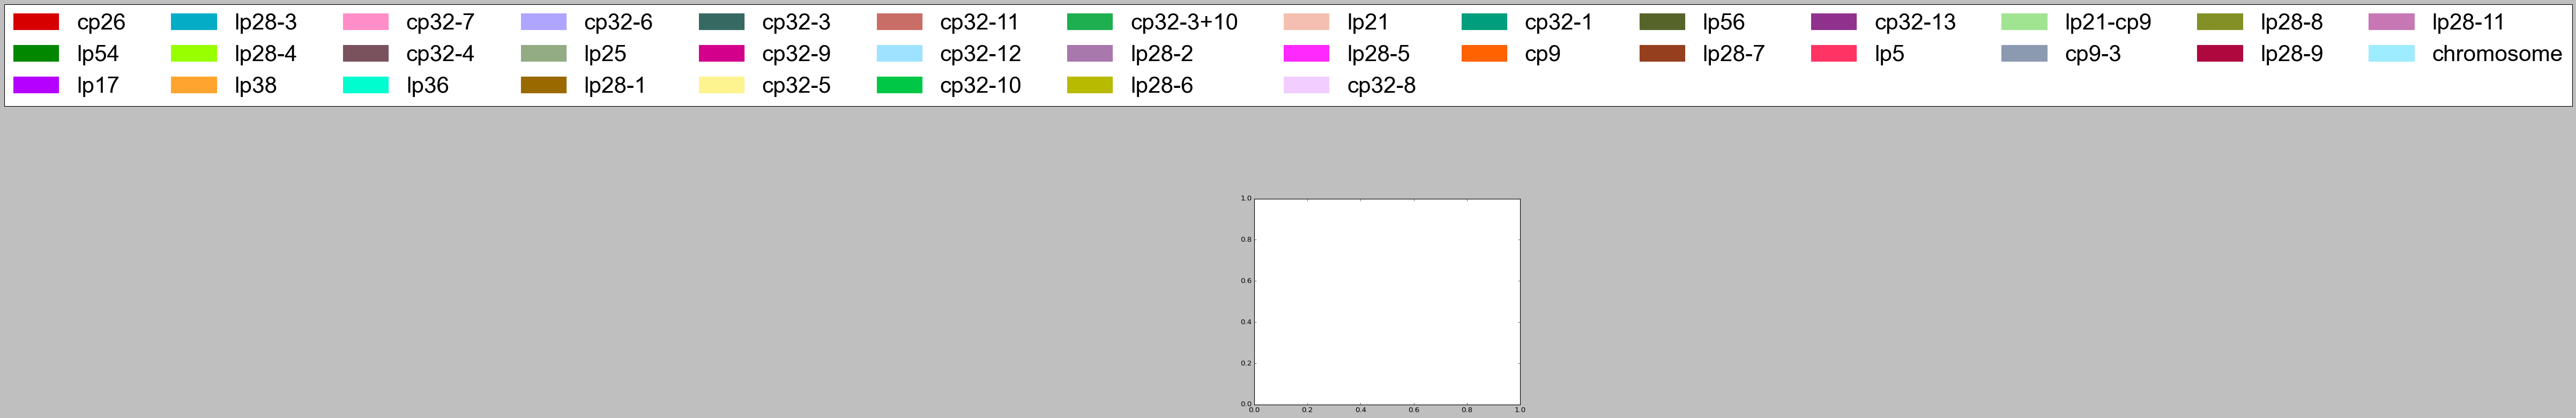

In [134]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('classic')
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "Arial"
plasmid_legend = [mpatches.Patch(color=color, label=f'{p}') for p, color in color_map.items()]
ax.legend(handles=plasmid_legend,
               ncol=14,
               fontsize=38,
               bbox_to_anchor=(5,2))
plt.savefig('asms_ava_homology_legend_v2.png')

In [50]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [45]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Split replicon color dict into chromosome, lp, and cp parts
chrom_dict = {k: v for k, v in color_map.items() if k.startswith('chrom')}
lp_dict = {k: v for k, v in color_map.items() if k.startswith('lp')}
cp_dict = {k: v for k, v in color_map.items() if k.startswith('cp')}

# Ensure all dictionaries are the same length so that legend will fit nicely into three rows / columns
def pad_dict(d, max_len):
    while len(d) < max_len:
        d[''] = ''
    return d

max_len = max(len(chrom_dict), len(lp_dict), len(cp_dict))
chrom_dict = pad_dict(chrom_dict, max_len)
lp_dict = pad_dict(lp_dict, max_len)
cp_dict = pad_dict(cp_dict, max_len)

# Go from dictionary to legend. handles
def create_legend_row(d):
    return [Line2D([0], [0], color=v, lw=4, label=k) for k, v in d.items() if k and v]

legend_elements = create_legend_row(chrom_dict) + create_legend_row(lp_dict) + create_legend_row(cp_dict)

# Add in the legend
ax.legend(handles=legend_elements, loc='center', ncol=max_len)

# If you want to do vertical instead of horizontal:
# ax.legend(handles=legend_elements, loc='center', ncol=3)

KeyboardInterrupt: 

In [135]:
#idmap[idmap['name'] == 'URI88H' ]#& idmap['contig'] == 'contig000017')]
idmap[idmap['best_hit'] == 'cp32-9-4']

,name,method,contig,contig_len,wp_alignment_id,pf_alignment_id,wp_plasmid_name,pf_plasmid_name,best_hit
6443,URI33,shortread,NODE_42_length_1753_cov_480.815632,1753,CP019921.1,0,cp32-9-4,0,cp32-9-4
9108,UNY208,shortread,NODE_43_length_1699_cov_385.588,1699,CP019921.1,0,cp32-9-4,0,cp32-9-4
10788,ESI26H,longread,contig000015,1297,CP019921.1,0,cp32-9-4,0,cp32-9-4
11125,URI40H,longread,contig000025,1150,CP019921.1,0,cp32-9-4,0,cp32-9-4
12970,URI42H,longread,contig000023,1150,CP019921.1,0,cp32-9-4,0,cp32-9-4
14814,UCT29,shortread,NODE_42_length_2265_cov_119.608775,2265,CP019921.1,0,cp32-9-4,0,cp32-9-4


In [99]:
longread_idmap = idmap[idmap['method'] == 'longread']
# Create a dictionary mapping contig names to their labels and groups
node_dict = longread_idmap.apply(lambda x: f"{x['name']}_{x['contig']}", axis=1)
node_dict = dict(zip(node_dict, longread_idmap['best_hit']))

In [102]:
for key, data in node_dict.items():
